In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import joblib

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import OLS, add_constant
from statsmodels.tools.eval_measures import aic, bic

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge, Lasso, ElasticNet

import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dubai-Houses/Data/processed/target-encoded-with-outliers/df_train.csv', sep=',')
df_valid = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dubai-Houses/Data/processed/target-encoded-with-outliers/df_valid.csv', sep=',')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dubai-Houses/Data/processed/target-encoded-with-outliers/df_test.csv', sep=',')

In [5]:
df_train.head()

,price,beds,baths,average_rent,year_of_completion,total_parking_spaces,total_floors,total_building_area_sqft,elevators,price_y,year,month,quarter,price_category_te,type_te,furnishing_te,completion_status_te,building_name_te,area_name_te,city_te
0,23000000,4,5,284778,0,0,0,0,0,25.842339,2023,12,4,22.981627,22.520592,20.929097,20.803653,21.046198,22.071653,21.052723
1,4794000,5,6,0,0,0,0,0,0,22.505769,2024,4,2,22.993396,21.246806,20.919776,21.032621,21.028478,21.848041,20.425342
2,1650000,3,4,129166,0,0,0,0,0,20.371980,2024,2,1,20.756294,20.408121,20.919776,20.795506,21.028478,19.387561,20.996193
3,3300000,4,5,223020,0,0,0,0,0,21.746551,2024,3,1,22.981627,21.293654,20.929097,20.803653,21.046198,21.582735,21.052723
4,2350000,2,3,158650,2007,0,53,454,0,21.067720,2023,11,4,20.752782,20.399543,20.786766,20.803653,20.939200,22.204246,21.052723


In [6]:
from tqdm.auto import tqdm

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn import tree
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [7]:
X_train = df_train.drop(['price', 'price_y'], axis = 1)

y_train = df_train['price_y']

In [8]:
cv5 = KFold(
    n_splits = 5,
    shuffle = True,
    random_state = 123
)

In [9]:
cv2 = KFold(
    n_splits = 2,
    shuffle = True,
    random_state = 123
)

In [10]:
# pipeline (no scaler needed for trees)
dt_pipeline = Pipeline(
    [
        ('model', DecisionTreeRegressor())
    ]
)

# sensible hyperparameter grid for your dataset
param_grid = {
    'model__max_depth': [3, 5, 7, 10, None],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 5, 10],
    'model__max_leaf_nodes': [None, 20, 50, 100],
    'model__ccp_alpha': [0.0, 0.0001, 0.001]
}

dt_grid_search = GridSearchCV(
    estimator = dt_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    cv = cv5,
    n_jobs = 5
)

dt_grid_search.fit(X_train, y_train)

model_dt_best = dt_grid_search.best_estimator_

print("Best params:", dt_grid_search.best_params_)
print("Best (negative) MAE:", dt_grid_search.best_score_)

Best params: {'model__ccp_alpha': 0.0, 'model__max_depth': None, 'model__max_leaf_nodes': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 20}
Best (negative) MAE: -0.33408523093797887


In [11]:
joblib.dump(model_dt_best, '/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_dt_best.pkl')

['/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_dt_best.pkl']

In [12]:
dt = model_dt_best.named_steps['model']   # get the DecisionTreeRegressor
text_representation = tree.export_text(dt)

# print(text_representation)

In [13]:
# check how many features are in the model
dt.n_features_in_

18

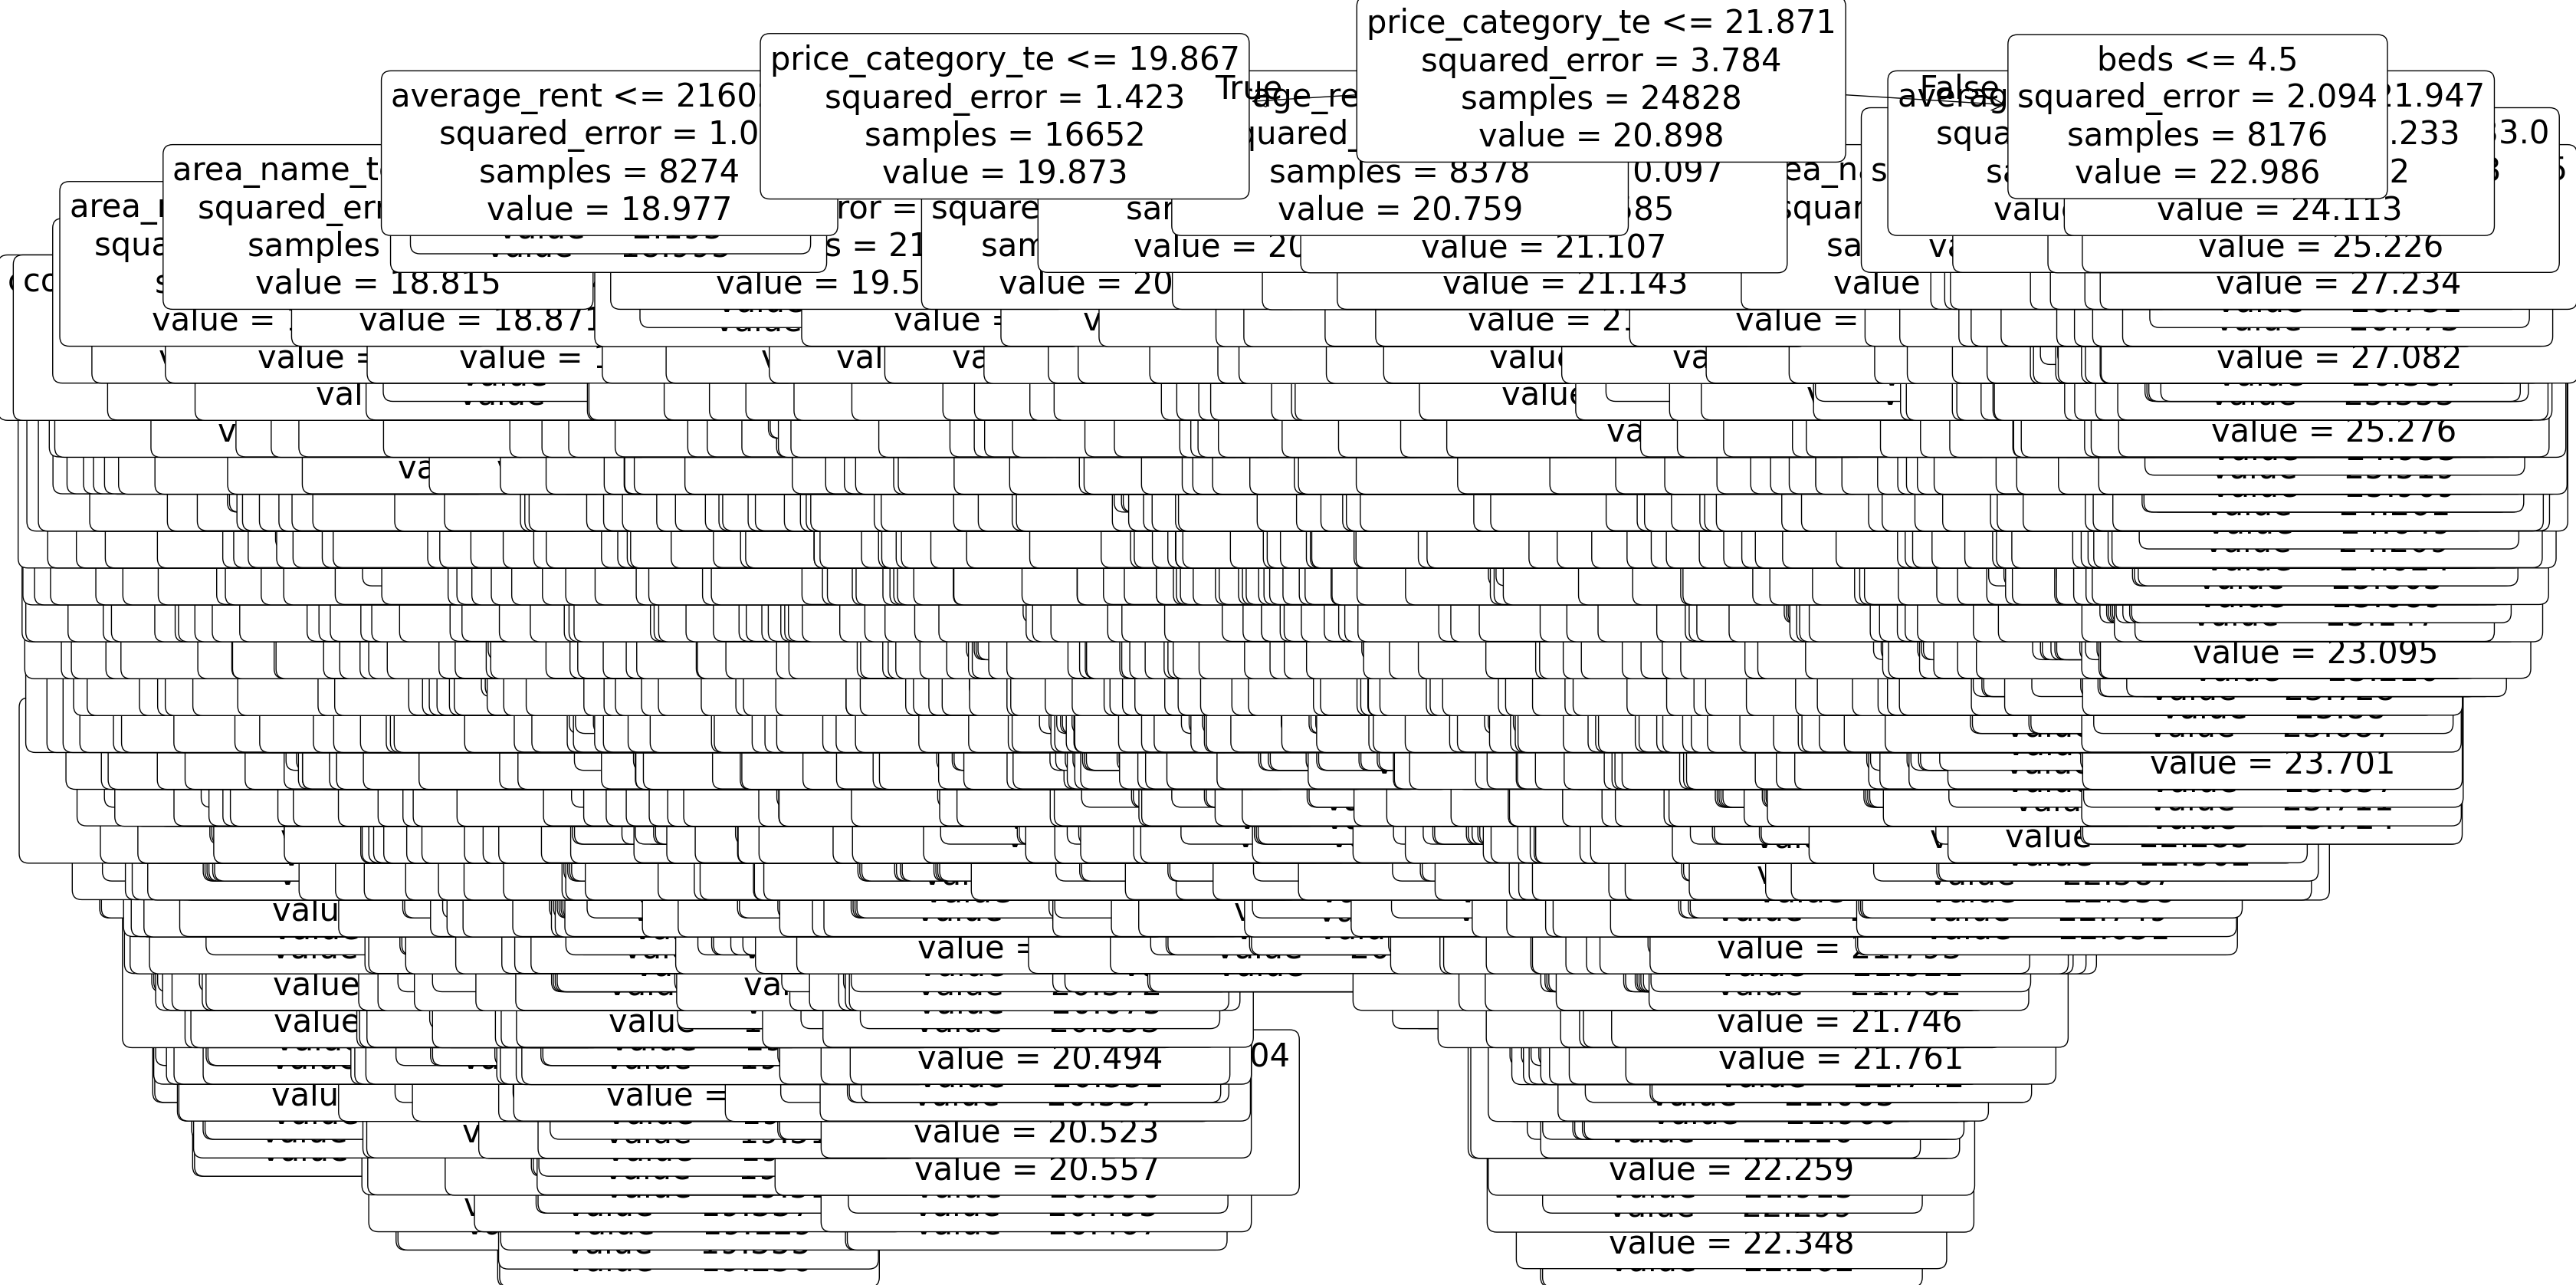

In [14]:
fig = plt.figure(figsize=(35, 20))

tree.plot_tree(
    dt,
    feature_names = list(X_train),
    filled = False,
    fontsize = 30,
    rounded = True
)
# plt.grid(True)
# plt.tight_layout()
plt.show()

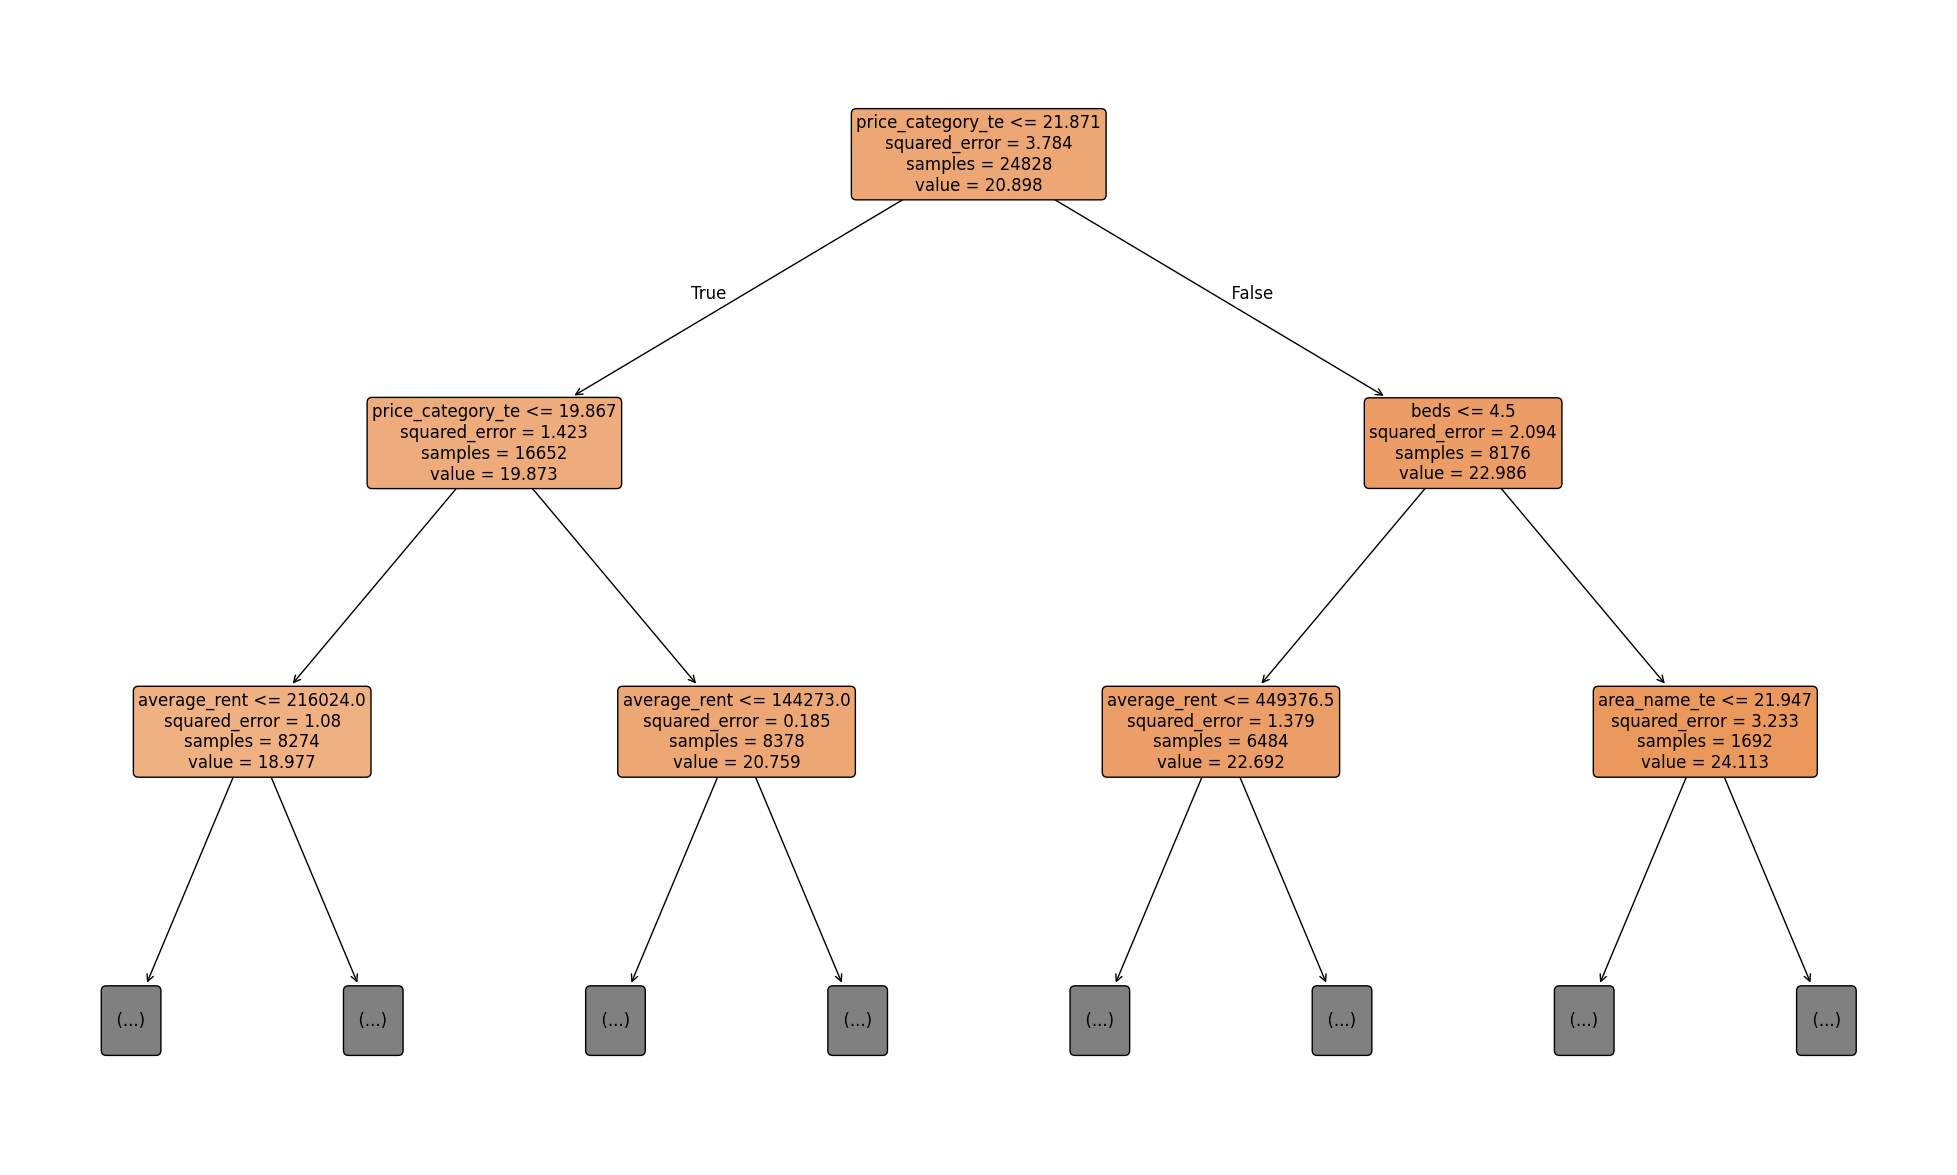

In [16]:
fig = plt.figure(figsize=(25, 15))
tree.plot_tree(
    dt,
    feature_names=list(X_train),
    max_depth=2,        # <— only show top 3 levels
    filled=True,
    fontsize=12,
    rounded=True
)
plt.show()

In [17]:
# additional DecisionTreeRegressor model

# pipeline (trees don't need scaling)
dt_pipeline = Pipeline([
    ('model', DecisionTreeRegressor(random_state=124))
])

# expanded hyperparameter grid (your notes, adapted to pipeline syntax)
param_grid = {
    'model__criterion': ['squared_error', 'friedman_mse'],  # exclude poisson if y <= 0
    'model__splitter': ['best', 'random'],
    'model__max_depth': [None, 3, 4, 5, 6, 8, 10],
    'model__min_samples_split': [2, 3, 5, 10],
    'model__min_samples_leaf': [1, 2, 3, 4],
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__ccp_alpha': np.linspace(0.0, 0.02, 11)
}

# remove poisson if target has non-positive values
if (y_train <= 0).any():
    param_grid['model__criterion'] = ['squared_error', 'friedman_mse']

dt_grid_search = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=cv2,
    n_jobs=1,
    verbose = 1
)

dt_grid_search.fit(X_train, y_train)

model_dt_best2 = dt_grid_search.best_estimator_

print("Best params:", dt_grid_search.best_params_)
print("Best (negative) MAE:", dt_grid_search.best_score_)

Fitting 2 folds for each of 14784 candidates, totalling 29568 fits
Best params: {'model__ccp_alpha': np.float64(0.0), 'model__criterion': 'friedman_mse', 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__splitter': 'best'}
Best (negative) MAE: -0.36216602407350273


In [18]:
joblib.dump(model_dt_best2, '/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_dt_best2.pkl')

['/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_dt_best2.pkl']

In [19]:
from sklearn.ensemble import BaggingRegressor

In [21]:
# second trial after first one took so much time

# pipeline (trees don't need scaling)
bagging_pipeline = Pipeline([
    ('model', BaggingRegressor(
        estimator = DecisionTreeRegressor(random_state=124),
        n_jobs = -1,
        oob_score = True,
        random_state = 124
    ))
])

# hyperparameter grid
param_grid = {
    'model__n_estimators': [20, 40], # [20, 40]
    'model__max_samples': [0.5, 0.7, 1.0], # [0.7]
    'model__bootstrap': [True],          # bagging
    'model__estimator__max_depth': [None, 5, 7, 10], # [None, 7]
    'model__estimator__min_samples_split': [2, 10],  # [2, 10]
    'model__estimator__min_samples_leaf': [1, 2, 4], # [1, 2]
    'model__estimator__ccp_alpha': [0.0, 0.001] # [0.0]
}

bagging_grid_search = GridSearchCV(
    estimator = bagging_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    cv = cv2,
    n_jobs = -1,
    verbose = 1   # <--- THIS prints progress like tqdm
)

bagging_grid_search.fit(X_train, y_train)

model_bagging_best = bagging_grid_search.best_estimator_

print("Best params:", bagging_grid_search.best_params_)
print("Best (negative) MAE:", bagging_grid_search.best_score_)

Fitting 2 folds for each of 288 candidates, totalling 576 fits
Best params: {'model__bootstrap': True, 'model__estimator__ccp_alpha': 0.0, 'model__estimator__max_depth': None, 'model__estimator__min_samples_leaf': 2, 'model__estimator__min_samples_split': 2, 'model__max_samples': 1.0, 'model__n_estimators': 40}
Best (negative) MAE: -0.3130402335378545


In [22]:
joblib.dump(model_bagging_best, '/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_bagging_best.pkl')

['/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_bagging_best.pkl']

In [23]:
from sklearn.ensemble import RandomForestRegressor

# pipeline (trees don't need scaling)
rf_pipeline = Pipeline([
    ('model', RandomForestRegressor(
        n_jobs = -1,
        random_state = 124,
        bootstrap = True,
        oob_score = False   # can enable later if needed
    ))
])

# hyperparameter grid (optimized for speed + performance)
param_grid = {
    'model__n_estimators': [100, 200],          # enough for stability
    'model__max_depth': [None, 10, 20],         # deep enough, not too slow
    'model__min_samples_split': [2, 10],        # controls overfitting
    'model__min_samples_leaf': [1, 2],          # robust to outliers
    'model__max_features': ['sqrt', 'log2'],    # best for one-hot encoded data
    'model__ccp_alpha': [0.0]                   # RF rarely benefits from pruning
}

rf_grid_search = GridSearchCV(
    estimator = rf_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    cv = cv2,            # faster than 5-fold, enough for RF
    n_jobs = -1,
    verbose = 1
)

rf_grid_search.fit(X_train, y_train)

model_rf_best = rf_grid_search.best_estimator_

print("Best params:", rf_grid_search.best_params_)
print("Best (negative) MAE:", rf_grid_search.best_score_)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
Best params: {'model__ccp_alpha': 0.0, 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best (negative) MAE: -0.3212624801730762


In [24]:
joblib.dump(model_rf_best, '/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_rf_best.pkl')

['/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_rf_best.pkl']

In [25]:
rf = model_rf_best.named_steps['model']
one_tree = rf.estimators_[0]

# print(tree.export_text(one_tree))


In [26]:
# check how many features are in the model
rf.n_features_in_

18

In [27]:
# # pick a single tree from the forest
one_tree = rf.estimators_[0]

# plt.figure(figsize=(35, 20))
# tree.plot_tree(
#     one_tree,
#     feature_names=list(X_train),
#     filled=False,
#     fontsize=30,
#     rounded=True
# )
# plt.show()


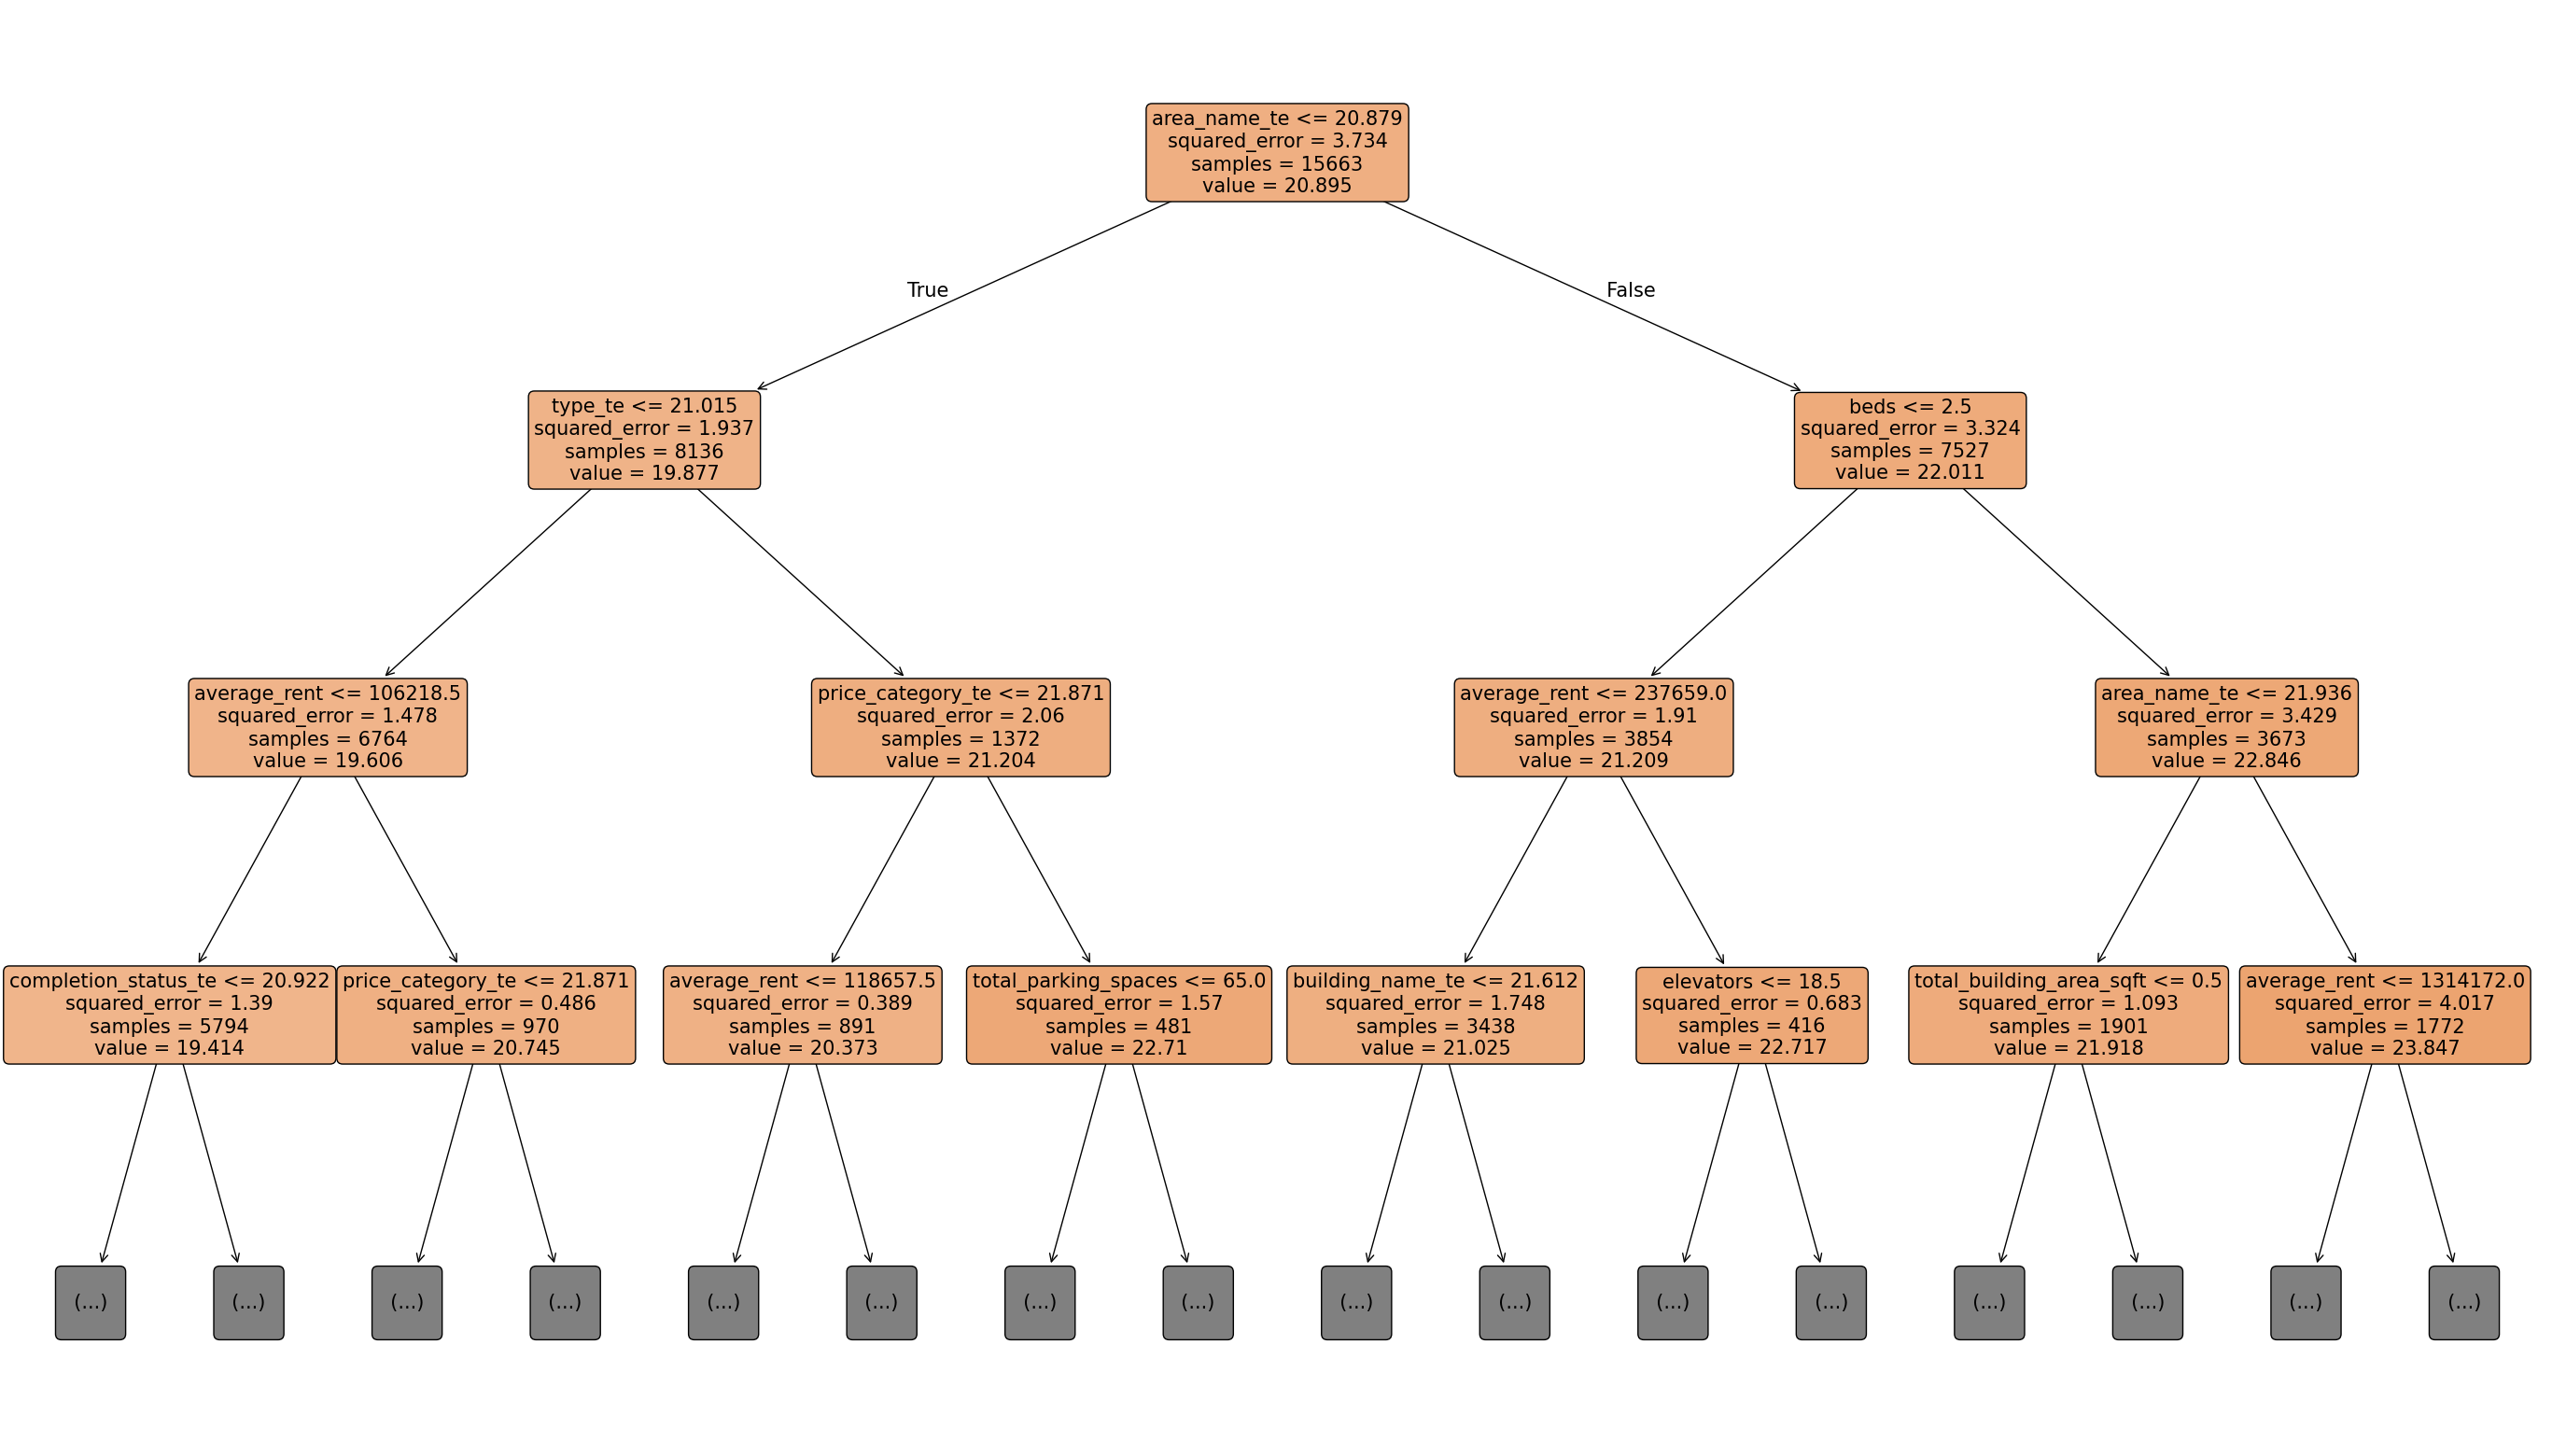

In [28]:
# pick a single tree from the forest
one_tree = rf.estimators_[0]

plt.figure(figsize=(35, 20))
tree.plot_tree(
    one_tree,
    feature_names=list(X_train),
    max_depth = 3,
    filled=True,
    fontsize=15,
    rounded=True
)
plt.show()


In [29]:
from sklearn.ensemble import AdaBoostRegressor

# pipeline (trees don't need scaling)
ada_pipeline = Pipeline([
    ('model', AdaBoostRegressor(
        estimator = DecisionTreeRegressor(random_state=124),
        random_state = 124
    ))
])

# hyperparameter grid (fast + effective)
param_grid = {
    'model__n_estimators': [50, 100, 200],      # boosting rounds
    'model__learning_rate': [0.01, 0.05, 0.1],  # shrinkage
    'model__estimator__max_depth': [2, 3, 4],   # shallow trees work best
    'model__estimator__min_samples_leaf': [1, 2]
}

ada_grid_search = GridSearchCV(
    estimator = ada_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',   # MAE is correct for AdaBoost
    cv = cv2,
    n_jobs = -1,
    verbose = 1
)

ada_grid_search.fit(X_train, y_train)

model_adaboost_best = ada_grid_search.best_estimator_

print("Best params:", ada_grid_search.best_params_)
print("Best (negative) MAE:", ada_grid_search.best_score_)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
Best params: {'model__estimator__max_depth': 4, 'model__estimator__min_samples_leaf': 1, 'model__learning_rate': 0.01, 'model__n_estimators': 50}
Best (negative) MAE: -0.5509272955801114


In [30]:
joblib.dump(model_adaboost_best, '/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_adaboost_best.pkl')

['/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_adaboost_best.pkl']

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

# pipeline (trees don't need scaling)
gbr_pipeline = Pipeline([
    ('model', GradientBoostingRegressor(
        random_state = 124
    ))
])

# hyperparameter grid (fast + effective)
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [2, 3, 4],
    'model__min_samples_split': [2, 10],
    'model__min_samples_leaf': [1, 2]
}

gbr_grid_search = GridSearchCV(
    estimator = gbr_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    cv = cv2,
    n_jobs = -1,
    verbose = 1
)

gbr_grid_search.fit(X_train, y_train)

model_gbr_best = gbr_grid_search.best_estimator_

print("Best params:", gbr_grid_search.best_params_)
print("Best (negative) MAE:", gbr_grid_search.best_score_)

Fitting 2 folds for each of 108 candidates, totalling 216 fits
Best params: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best (negative) MAE: -0.3402969239519582


In [32]:
joblib.dump(model_gbr_best, '/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_gbr_best.pkl')

['/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_gbr_best.pkl']

In [33]:
from xgboost import XGBRegressor

# pipeline (trees don't need scaling)
xgb_pipeline = Pipeline([
    ('model', XGBRegressor(
        objective = 'reg:squarederror',
        tree_method = 'hist',      # fast for large + one-hot encoded data
        n_jobs = -1,
        random_state = 124
    ))
])

# hyperparameter grid (complete + fast)
param_grid = {
    'model__n_estimators': [200, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.7, 1.0],
    'model__colsample_bytree': [0.7, 1.0],
    'model__min_child_weight': [1, 3],
    'model__gamma': [0, 1],
    'model__reg_alpha': [0.0, 0.001],
    'model__reg_lambda': [1.0, 2.0]
}

xgb_grid_search = GridSearchCV(
    estimator = xgb_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    cv = cv2,
    n_jobs = -1,
    verbose = 1
)

xgb_grid_search.fit(X_train, y_train)

model_xgb_best = xgb_grid_search.best_estimator_

print("Best params:", xgb_grid_search.best_params_)
print("Best (negative) MAE:", xgb_grid_search.best_score_)

Fitting 2 folds for each of 1152 candidates, totalling 2304 fits
Best params: {'model__colsample_bytree': 1.0, 'model__gamma': 0, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__min_child_weight': 1, 'model__n_estimators': 400, 'model__reg_alpha': 0.0, 'model__reg_lambda': 1.0, 'model__subsample': 1.0}
Best (negative) MAE: -0.31050810736678713


In [34]:
joblib.dump(model_xgb_best, '/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_xgb_best.pkl')

['/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_xgb_best.pkl']

In [35]:
from sklearn.ensemble import StackingRegressor

# stacking pipeline using loaded models
stack_pipeline = Pipeline([
    ('model', StackingRegressor(
        estimators = [
            ('rf', model_rf_best.named_steps['model']),
            ('gbr', model_gbr_best.named_steps['model']),
            ('ada', model_adaboost_best.named_steps['model']),
            ('xgb', model_xgb_best.named_steps['model']),
            ('bag', model_bagging_best.named_steps['model']),
            ('dt', model_dt_best2.named_steps['model'])
        ],
        final_estimator = LinearRegression(),
        n_jobs = -1,
        passthrough = False
    ))
])

# small grid (stacking is heavy)
param_grid = {
    'model__final_estimator__fit_intercept': [True, False]
}

stack_grid_search = GridSearchCV(
    estimator = stack_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    cv = cv2,
    n_jobs = -1,
    verbose = 1
)

stack_grid_search.fit(X_train, y_train)

model_stacking_best = stack_grid_search.best_estimator_

print("Best params:", stack_grid_search.best_params_)
print("Best (negative) MAE:", stack_grid_search.best_score_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best params: {'model__final_estimator__fit_intercept': False}
Best (negative) MAE: -0.3043100288865307


In [37]:
joblib.dump(model_stacking_best, '/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_stacking_best.pkl')

['/content/drive/My Drive/Colab Notebooks/Dubai-Houses/models/3_models/model_stacking_best.pkl']

Why did I target encode the valid and test samples???

Why did I IQR valid and test samples???